In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from pypfopt import EfficientFrontier, expected_returns, risk_models
import warnings
warnings.filterwarnings('ignore')

##### Step1: Regime classification

In [2]:
# ===========================
# Preprocess Data
# ===========================
# Import and merge macro data
csv_files = glob.glob("macro*.csv")
dataframes = []
for file in csv_files:
    base_name = os.path.splitext(os.path.basename(file))[0]
    col_name = base_name.replace("macro_", "")
    df = pd.read_csv(file, parse_dates=['observation_date'])
    df.set_index('observation_date', inplace=True)
    df.columns = [col_name]
    dataframes.append(df)
merged_df = pd.concat(dataframes, axis=1, join='outer')

# Get market data
market_data = yf.download('^GSPC', start='1989-12-01', interval='1mo', auto_adjust=True, progress=False)['Close']
market_data['sp500_1m_return'] = market_data['^GSPC'].pct_change(1)
market_data['sp500_2m_return'] = market_data['^GSPC'].pct_change(2)
market_data['sp500_3m_return'] = market_data['^GSPC'].pct_change(3)
return_cols = [col for col in market_data.columns if 'return' in col]
return_data = market_data[return_cols]
merged_df = merged_df.merge(return_data, left_index=True, right_index=True, how='outer')

# Clean data
macro_df = merged_df.copy()
cols_to_change = ['10yrTrYield','consumerSentiment', 'cpi', 'housingStarts',
                  'industryProduction', 'leadingIndex', 'newOrders', 'retailSales']
for col in cols_to_change:
    if col in macro_df.columns:
        macro_df[f'{col}_change'] = macro_df[col].pct_change(fill_method=None)
        macro_df.drop(columns=col, inplace=True)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")
macro_df['gdpGrowth'] = macro_df['gdpGrowth'].ffill()

# Create lag terms
cols_to_lag = ['unemploymentRate', 'ffRate', 'cpi_change', 
               '10y2y', 'corporateSpread', 'industryProduction_change']
for col in cols_to_lag:
    if col in macro_df.columns:
        macro_df[f'{col}_lag1'] = macro_df[col].shift(1)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")
macro_df[[f"{col}_lag1" for col in cols_to_lag if f"{col}_lag1" in macro_df.columns]]

macro_df.dropna(inplace=True)


# ===========================
# Check Stationarity 
# ===========================
def check_stationarity(df):
    """Check and drop non-stationary series."""
    stationary_df = df.copy()
    dropped_cols = []

    for col in df.columns:
        p_val = adfuller(df[col].dropna())[1]
        if p_val >= 0.05: #non-stationary
            dropped_cols.append(col)
    stationary_df = stationary_df.drop(columns=dropped_cols)
    
    return stationary_df, dropped_cols

macro_stationary_df, macro_dropped_cols = check_stationarity(macro_df)
if len(macro_dropped_cols) == 0:
    print('All variables are stationary.')
else:
    print(f'Dropped factors:{macro_dropped_cols}')
    print(f'Remaining factors:{macro_stationary_df.columns}')

All variables are stationary.


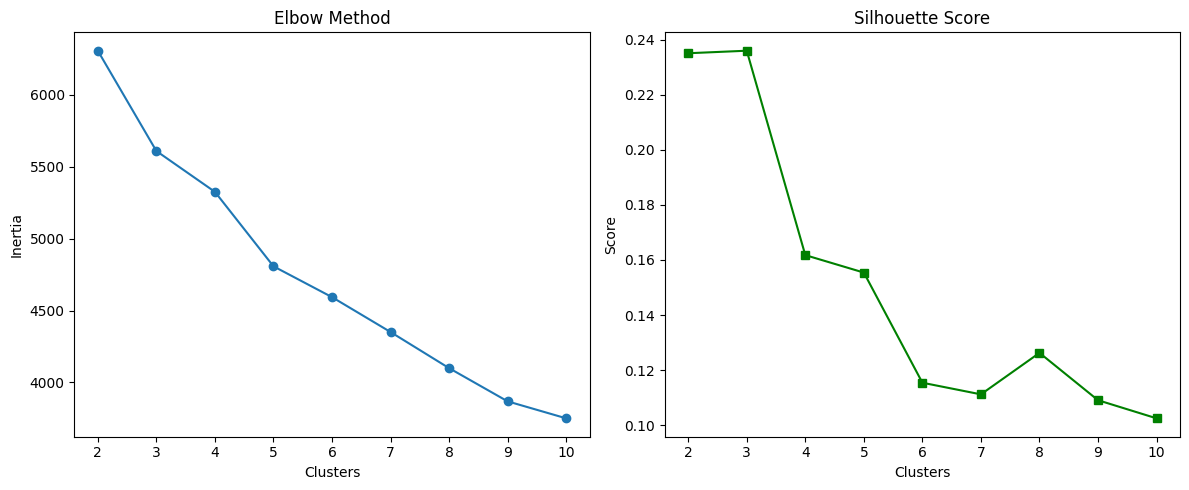

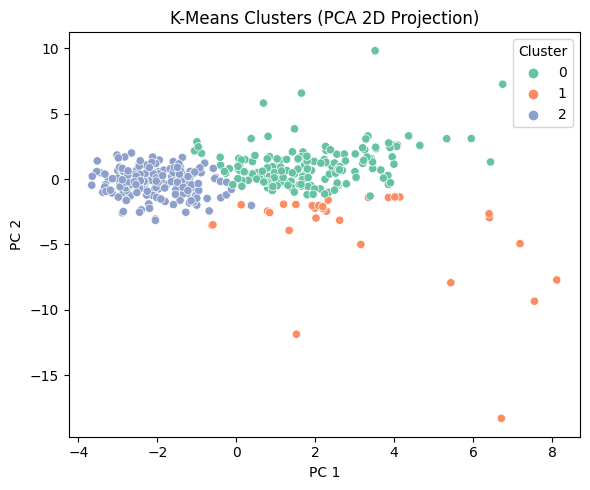

cluster_pca,0,1,2
10y2y,1.828421,1.541613,0.231237
corporateSpread,2.608596,3.620968,1.883144
ffRate,0.908480,1.323226,4.288918
gdpGrowth,2.230409,0.458065,3.265464
unemploymentRate,6.888304,6.445161,4.465464
sp500_1m_return,0.015084,-0.048829,0.010164
sp500_2m_return,0.029734,-0.095820,0.020632
sp500_3m_return,0.040852,-0.124802,0.031023
10yrTrYield_change,0.013567,-0.084043,0.004427
consumerSentiment_change,0.006553,-0.018145,-0.000482


In [3]:
# ===========================
# PCA-based Clustering
# ===========================

# Step 1: Standardize and apply PCA
scaler = StandardScaler()
macro_scaled = scaler.fit_transform(macro_stationary_df)

pca = PCA(n_components=0.9)  # retain 90% variance
macro_pca = pca.fit_transform(macro_scaled)

# Step 2: Find optimal number of clusters
def evaluate_kmeans(data, k_range):
    inertias, silhouettes = [], []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(data, labels))
    return inertias, silhouettes

k_range = range(2, 11)
inertias, silhouettes = evaluate_kmeans(macro_pca, k_range)

# Step 3: Plot Elbow & Silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method'); plt.xlabel('Clusters'); plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, marker='s', color='green')
plt.title('Silhouette Score'); plt.xlabel('Clusters'); plt.ylabel('Score')
plt.tight_layout(); plt.show()

# Step 4: Fit optimal KMeans
optimal_k = 3
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42)
macro_df['cluster_pca'] = kmeans_pca.fit_predict(macro_pca)

# ===========================
# Cluster Interpretation
# ===========================
# PCA visualization
pca_2d = PCA(n_components=2).fit_transform(macro_scaled)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=macro_df['cluster_pca'], palette='Set2')
plt.title('K-Means Clusters (PCA 2D Projection)')
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.legend(title='Cluster'); plt.tight_layout(); plt.show()

# Cluster summary
cluster_means = macro_df.groupby('cluster_pca').mean()
display(cluster_means.T)

Interpretation:
1. Cluster 0: Recovery / Early Expansion (High GDP growth & returns, high unemployment, improving yields & sentiment)
2. Cluster 1: Contraction (Low growth, negative returns, wide spreads, falling yields, poor sentiment)
3. Cluster 2: Peak / Late Expansion (Strong growth, low unemployment, low spreads, high rates, decent returns)

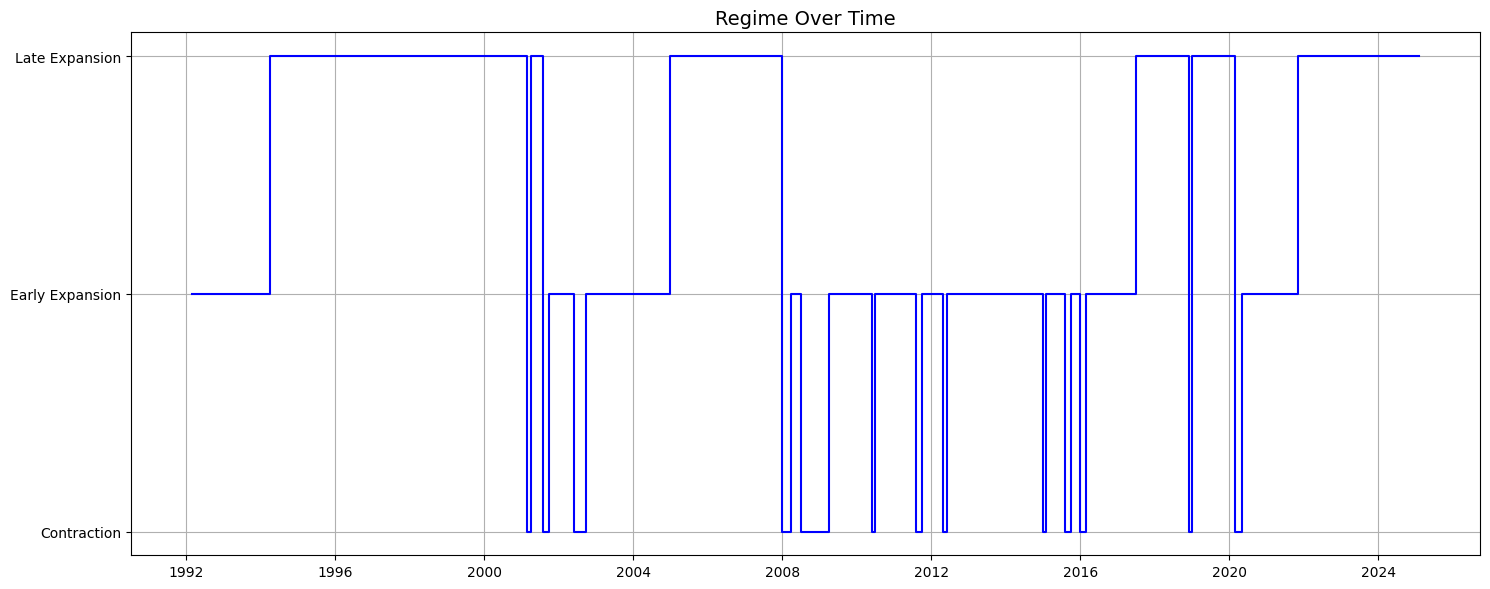

In [4]:
# ===========================
# Cluster Interpretation (Continue)
# ===========================
# Define regime names
cluster_names = {0: 'Early Expansion', 1: 'Contraction', 2: 'Late Expansion'}
macro_df['regime'] = macro_df['cluster_pca'].map(cluster_names)
regimes_order = ['Contraction', 'Early Expansion', 'Late Expansion']
macro_df['regime'] = pd.Categorical(macro_df['regime'], categories=regimes_order, ordered=True)

# Plot regimes by time
plt.figure(figsize=(15, 6))
plt.step(macro_df.index, macro_df['regime'].cat.codes, where='post', color='b', label='Regime')
plt.title('Regime Over Time', fontsize=14)
plt.yticks(ticks=range(len(regimes_order)), labels=regimes_order)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Step 2: Asset class performance per regime


=== Regime: Contraction ===


,asset,Avg Return,Volatility,Sharpe Ratio,Max Drawdown
13,2-Year Treasury,0.060524,0.016466,3.079791,0.005813
12,10-Year Treasury,0.256348,0.080318,3.069502,0.045935
15,Gold,0.212862,0.247036,0.808101,0.270589
14,Corporate Bond,0.073383,0.149024,0.426589,0.131379
18,Wheat,-0.079038,0.324288,-0.284532,0.595669
19,Bitcoin,-0.626981,0.786442,-0.803722,0.411943
20,USD/EUR,-0.123522,0.156420,-0.848338,0.308807
17,Corn,-0.357023,0.352899,-1.049182,0.766057
21,USD/JPY,-0.144142,0.114840,-1.370382,0.371060
11,Communication,-0.381413,0.249499,-1.581751,0.686248


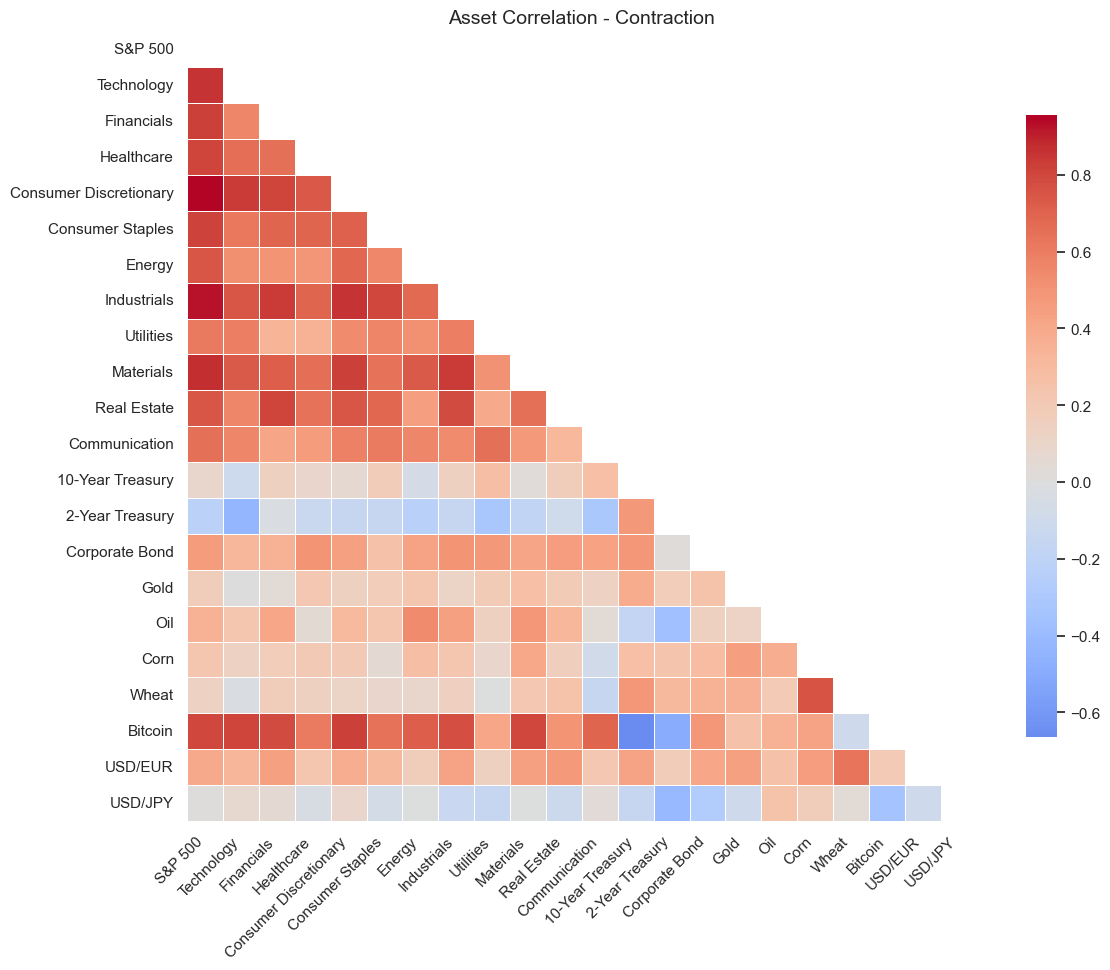


=== Regime: Early Expansion ===


,asset,Avg Return,Volatility,Sharpe Ratio,Max Drawdown
41,Bitcoin,1.390495,0.667378,2.079627,0.405269
26,Consumer Discretionary,0.246098,0.148980,1.606237,0.125693
22,S&P 500,0.183614,0.116260,1.502751,0.101633
29,Industrials,0.217486,0.154107,1.367133,0.125272
31,Materials,0.233995,0.169404,1.341137,0.119402
23,Technology,0.259461,0.193142,1.308153,0.236001
24,Financials,0.225393,0.174770,1.250740,0.238434
32,Real Estate,0.222982,0.182240,1.198107,0.145442
25,Healthcare,0.143348,0.116931,1.167749,0.188486
27,Consumer Staples,0.123173,0.103135,1.128341,0.096242


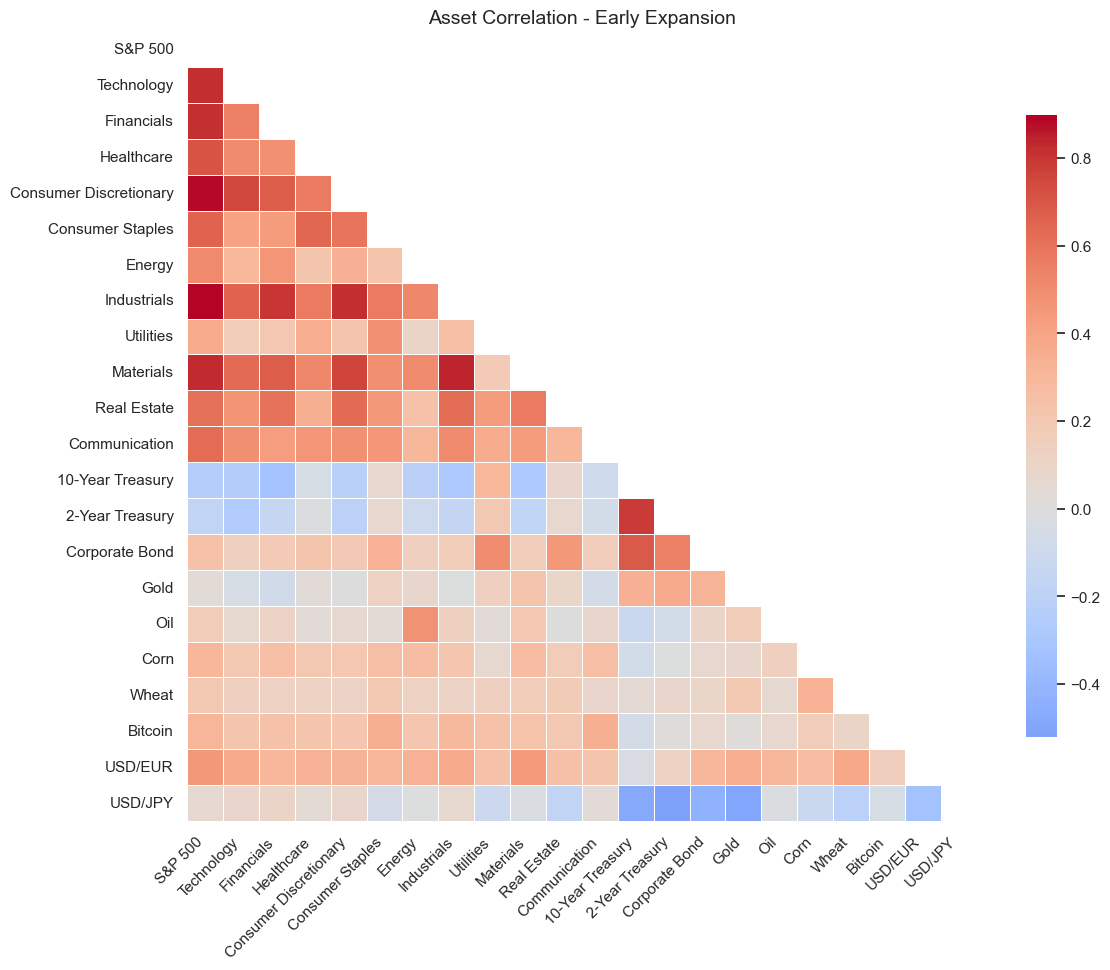


=== Regime: Late Expansion ===


,asset,Avg Return,Volatility,Sharpe Ratio,Max Drawdown
59,Gold,0.140334,0.126978,0.822906,0.160733
47,Healthcare,0.146673,0.151441,0.685308,0.184822
63,Bitcoin,0.545986,0.769745,0.671461,0.824044
45,Technology,0.209372,0.253817,0.655918,0.585197
44,S&P 500,0.121964,0.137867,0.573557,0.288075
51,Industrials,0.118845,0.159255,0.476943,0.287833
49,Consumer Staples,0.102676,0.134030,0.446074,0.312149
46,Financials,0.126499,0.188126,0.444438,0.350360
50,Energy,0.133285,0.232811,0.412190,0.348142
52,Utilities,0.093942,0.149209,0.342158,0.210700


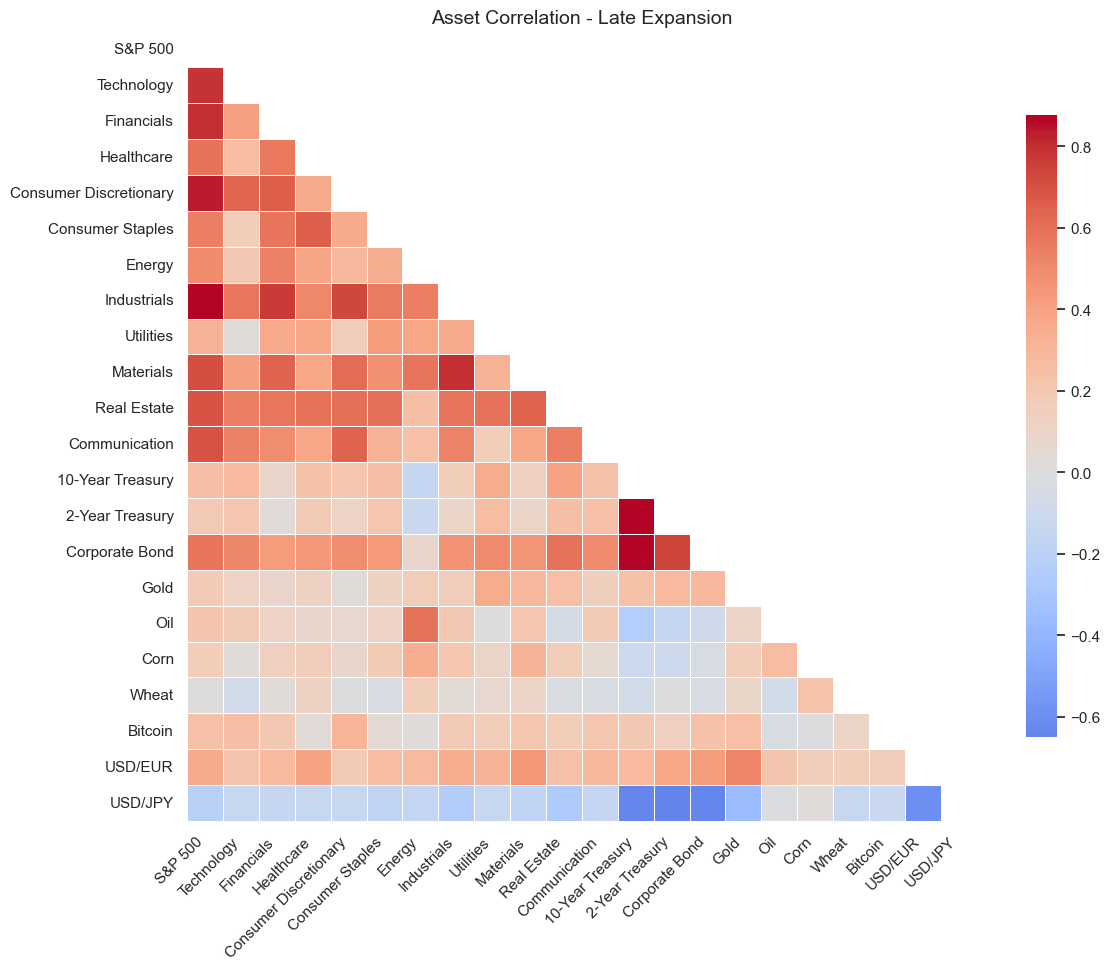

In [5]:
# ===========================
# Asset Data Prep
# ===========================
# Download and clean asset prices
tickers = {
    'S&P 500': '^GSPC', 'Technology': '^SP500-45', 'Financials': '^SP500-40', 'Healthcare': '^SP500-35',
    'Consumer Discretionary': '^SP500-25', 'Consumer Staples': '^SP500-30', 'Energy': '^SP500-1010',
    'Industrials': '^SP500-20', 'Utilities': '^SP500-55', 'Materials': '^SP500-15', 'Real Estate': '^SP500-60',
    'Communication': '^SP500-50', '10-Year Treasury': 'IEF', '2-Year Treasury': 'SHY',
    'Corporate Bond': 'LQD', 'Gold': 'GC=F', 'Oil': 'CL=F', 'Corn': 'ZL=F', 'Wheat': 'ZW=F',
    'Bitcoin': 'BTC-USD', 'USD/EUR': 'EURUSD=X', 'USD/JPY': 'JPY=X'
}

daily_data = yf.download(list(tickers.values()), start='1989-12-01', auto_adjust=True, progress=False)['Close']
monthly_data = daily_data.resample('M').last()
assets_data = monthly_data.rename(columns={v: k for k, v in tickers.items()})
assets_data.index = assets_data.index.to_period('M').to_timestamp(how='start')

# Forward fill missing values
for col in assets_data.columns:
    first_valid = assets_data[col].first_valid_index()
    assets_data.loc[assets_data.index < first_valid, col] = np.nan
assets_data = assets_data.ffill()

# Merge with regimes and fed rate
assets_data = assets_data.merge(macro_df[['regime', 'ffRate']], left_index=True, right_index=True)

# ===========================
# Return & Metrics
# ===========================

# Calculate returns
asset_names = list(tickers.keys())
returns = assets_data[asset_names].pct_change()
returns['regime'] = assets_data['regime'].reindex(returns.index)
returns['ffRate'] = assets_data['ffRate'].reindex(returns.index) / 100 / 12 

# Compute performance metrics
def compute_metrics(group):
    rf = group['ffRate']
    metrics = {}
    for asset in asset_names:
        r = group[asset]
        excess = r - rf
        cumulative = (1 + r).cumprod()

        metrics[asset] = {
            'Avg Return': r.mean() * 12,  # annualized
            'Volatility': r.std() * np.sqrt(12), 
            'Sharpe Ratio': (excess.mean() * 12) / (r.std() * np.sqrt(12)) if r.std() > 0 else np.nan,
            'Max Drawdown': ((cumulative.cummax() - cumulative) / cumulative.cummax()).max(),
        }
    return pd.DataFrame(metrics).T

grouped_metrics = returns.groupby('regime').apply(compute_metrics)
grouped_metrics.index.names = ['regime', 'asset']
grouped_metrics = grouped_metrics.reset_index()


# ===========================
# Display Metrics & Heatmaps
# ===========================
sns.set(style="white")
cluster_corr_dict = {}
cluster_cov_dict = {}

for regime_name in grouped_metrics['regime'].unique():
    print(f"\n=== Regime: {regime_name} ===")
    
    # Display metrics sorted by Sharpe Ratio
    cluster_df = grouped_metrics[grouped_metrics['regime'] == regime_name]
    cluster_df_sorted = cluster_df.sort_values(by='Sharpe Ratio', ascending=False)
    display(cluster_df_sorted.drop(columns=['regime']))

    # Correlation matrix and heatmap
    cluster_returns = returns[returns['regime'] == regime_name][asset_names]
    cluster_corr_dict[regime_name] = cluster_returns.corr()
    cluster_cov_dict[regime_name] = cluster_returns.cov() * 12  # annualized

    corr_matrix = cluster_corr_dict[regime_name]
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(12, 10))
    plt.title(f'Asset Correlation - {regime_name}', fontsize=14)
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
                annot=True, fmt=".2f", linewidths=.5, square=True,
                cbar_kws={"shrink": .75})
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

##### Step 3: Asset allocation per regime 


=== Optimal Portfolio - Contraction ===
Method: max_sharpe
Expected Return: 18.45%
Volatility: 1.53%
Sharpe Ratio: 10.12
Asset Allocation:
  2-Year Treasury: 54.82%
  10-Year Treasury: 34.41%
  Gold: 10.77%


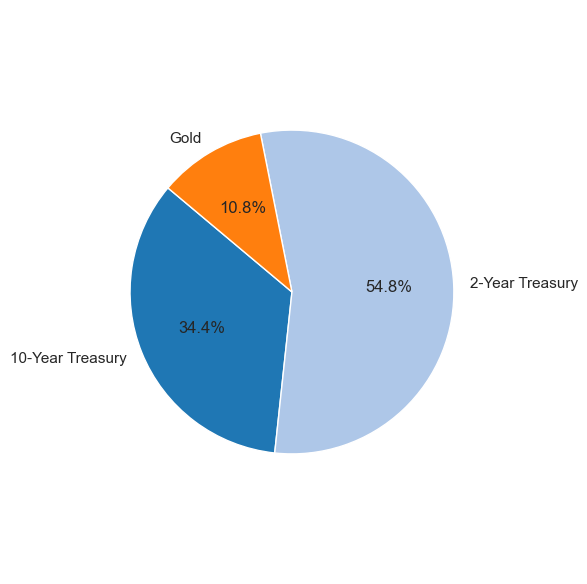


=== Optimal Portfolio - Early Expansion ===
Method: max_sharpe
Expected Return: 42.06%
Volatility: 4.57%
Sharpe Ratio: 8.55
Asset Allocation:
  Financials: 24.53%
  Healthcare: 22.29%
  Bitcoin: 16.41%
  Consumer Discretionary: 15.75%
  USD/JPY: 13.34%
  Technology: 7.69%


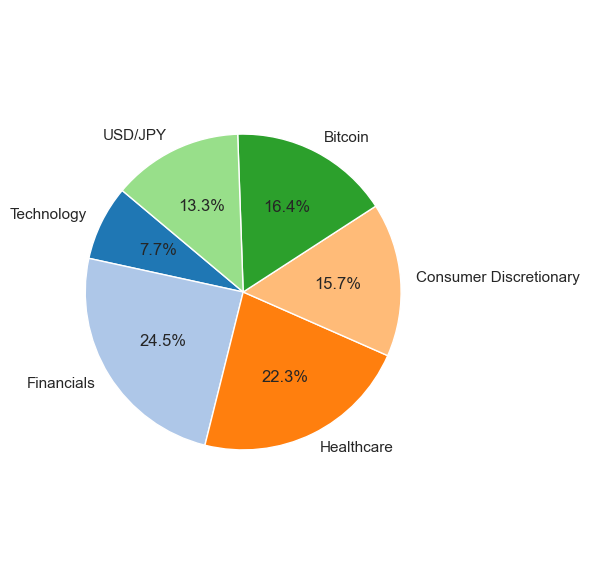


=== Optimal Portfolio - Late Expansion ===
Method: max_sharpe
Expected Return: 11.69%
Volatility: 2.20%
Sharpe Ratio: 3.94
Asset Allocation:
  USD/JPY: 35.99%
  Gold: 35.29%
  Technology: 13.99%
  Consumer Staples: 10.72%
  Bitcoin: 4.01%


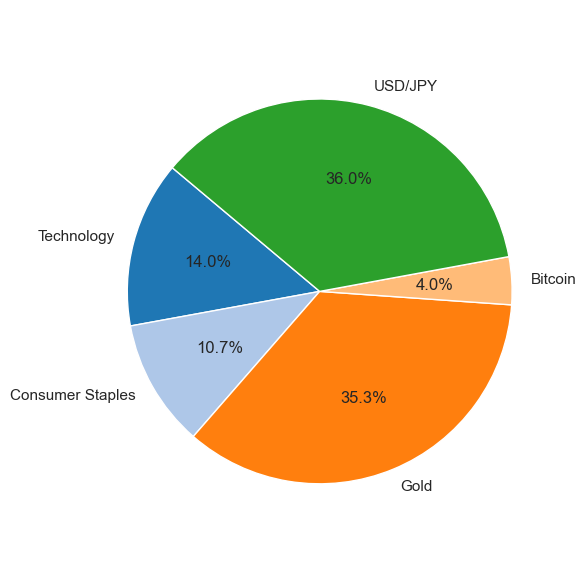

In [6]:
def optimize_portfolio(
    regime_data, asset_cov, annualized: bool = True,
    optimization_method: str = "max_sharpe", risk_free_rate: float = 0.03,
    target_volatility: float = None, target_return: float = None
):

    regime_data = regime_data.dropna()

    # Compute expected returns, covariance matrix
    mu = regime_data.mean() * 12 if annualized else regime_data.mean()
    S = risk_models.fix_nonpositive_semidefinite(asset_cov) /12
    ef = EfficientFrontier(mu, S)

    try:
        if optimization_method == "max_sharpe":
            weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
        elif optimization_method == "min_volatility":
            weights = ef.min_volatility()
        elif optimization_method == "efficient_risk":
            if target_volatility is None:
                raise ValueError("target_volatility must be provided for 'efficient_risk'")
            weights = ef.efficient_risk(target_volatility)
        elif optimization_method == "efficient_return":
            if target_return is None:
                raise ValueError("target_return must be provided for 'efficient_return'")
            weights = ef.efficient_return(target_return)
        else:
            raise ValueError(f"Unknown optimization method: {optimization_method}")

        cleaned_weights = ef.clean_weights()
        perf = ef.portfolio_performance(verbose=False)

        return {
            "weights": cleaned_weights,
            "performance": perf,
            "method": optimization_method,
        }

    except Exception as e:
        print(f"Optimization failed ({optimization_method}): {e}")
        ef = EfficientFrontier(mu, S)
        ef.min_volatility()
        cleaned_weights = ef.clean_weights()
        perf = ef.portfolio_performance(verbose=False)

        return {
            "weights": cleaned_weights,
            "performance": perf,
            "method": "min_volatility (fallback)",
        }

def optimization_results(result):
    print(f"Method: {result['method']}")
    print(f"Expected Return: {result['performance'][0]:.2%}")
    print(f"Volatility: {result['performance'][1]:.2%}")
    print(f"Sharpe Ratio: {result['performance'][2]:.2f}")

    print("Asset Allocation:")
    sorted_weights = sorted(result['weights'].items(), key=lambda x: x[1], reverse=True)
    for asset, weight in sorted_weights:
        if weight > 0:
            print(f"  {asset}: {weight:.2%}")
            
def plot_pie(result):
    selected_weights = {k: v for k, v in result['weights'].items() if v > 0}
    labels = list(selected_weights.keys())
    values = list(selected_weights.values())

    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
    plt.axis('equal') 
    plt.tight_layout()
    plt.show()

# ===========================
# Optimized asset allocation by regime
# ===========================
for regime_name in grouped_metrics['regime'].unique():
    print(f"\n=== Optimal Portfolio - {regime_name} ===")
    unfav_asset = ['Oil', 'Corn', 'Wheat']     # Drop unwanted assets
    regime_data = returns[returns['regime'] == regime_name].drop(columns=['regime', 'ffRate'])
    regime_data = regime_data.drop(columns=unfav_asset)
    cov = cluster_cov_dict[regime_name].drop(index=unfav_asset, columns=unfav_asset)
    result = optimize_portfolio(
        regime_data, cov,
        optimization_method="max_sharpe", risk_free_rate=0.03
    )
    
    optimization_results(result)
    plot_pie(result)

##### Step 4: Predict upcoming regime with leading indicators

In [7]:
# ----------------------------
# Model Data Prep
# ----------------------------
leading_indicators = [
    '10y2y', 'consumerSentiment_change', 'housingStarts_change', 'leadingIndex_change',
    'newOrders_change', 'retailSales_change', 'sp500_1m_return', 'sp500_2m_return',
    'sp500_3m_return', '10y2y_lag1', 'corporateSpread_lag1'
]

X, y = [], []
for i in range(6, len(macro_df)):
    X.append(macro_df[leading_indicators].iloc[i-3:i].values.flatten())
    y.append(macro_df['cluster_pca'].iloc[i])
X = pd.DataFrame(X)
y = pd.Series(y)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# ----------------------------
# Train Models
# ----------------------------

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# ----------------------------
# Evaluation
# ----------------------------
def evaluate_model(model, name):
    """
    Evaluates a given model and prints accuracy, classification report, and confusion matrix.
    """
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

evaluate_model(logreg, "Logistic Regression")
evaluate_model(rf, "Random Forest")
evaluate_model(xgb, "XGBoost")

# ----------------------------
# Predict Upcoming Regime
# ----------------------------
latest_input = X_scaled[-1].reshape(1, -1)

# Logistic Regression Prediction
logreg_pred = logreg.predict(latest_input)[0]
print(f"\nPredicted Upcoming Regime by Logistic Regression: {logreg_pred}")

# Random Forest Prediction
rf_pred = rf.predict(latest_input)[0]
print(f"\nPredicted Upcoming Regime by Random Forest: {rf_pred}")

# XGBoost Prediction
xgb_pred = xgb.predict(latest_input)[0]
print(f"\nPredicted Upcoming Regime by XGBoost: {xgb_pred}")



Logistic Regression Performance:
Accuracy: 0.9102564102564102
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        18
           1       0.33      0.33      0.33         3
           2       0.92      1.00      0.96        57

    accuracy                           0.91        78
   macro avg       0.75      0.69      0.71        78
weighted avg       0.92      0.91      0.91        78


Random Forest Performance:
Accuracy: 0.782051282051282
              precision    recall  f1-score   support

           0       1.00      0.22      0.36        18
           1       0.00      0.00      0.00         3
           2       0.77      1.00      0.87        57

    accuracy                           0.78        78
   macro avg       0.59      0.41      0.41        78
weighted avg       0.79      0.78      0.72        78


XGBoost Performance:
Accuracy: 0.782051282051282
              precision    recall  f1-score   support

           0  